In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession 
import pyspark.sql.functions as func
from string import punctuation as punc
from string import digits
import socket
import urllib, json
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(style="darkgrid")
plt.style.use("seaborn-pastel")

In [ ]:
conf = SparkConf().setAppName("Term_Project")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [ ]:
df_ratings = spark.read.format("csv").options(header=True,inferSchema=True).load("./ratings_small.csv")
#df_ratings = pd.read_csv("./data.tsv",sep="\t",low_memory=False, na_values=["\\N","nan"])
number_of_movies = df_ratings.select('movieId').distinct().collect()
print("Number of movies: ",len(number_of_movies))
print("Number of rows: ",df_ratings.count()) # number of rows

Number of movies:  9066
Number of rows:  100004


In [ ]:
df_ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [ ]:
df_ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
+------+-------+------+----------+
only showing top 5 rows



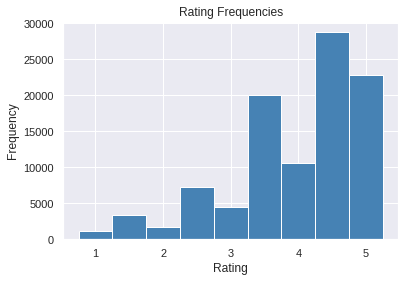

In [ ]:
ratings = df_ratings.select('rating').collect()
ratings_list = [ratings[i][0] for i in range(len(ratings))]
bin_edges = np.arange(0.5, 5.5, step=0.5)

plt.hist(ratings_list, bins=bin_edges,
         histtype='bar', color='steelblue',align='right')
plt.title("Rating Frequencies")
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

+-------+-----+
|movieId|count|
+-------+-----+
|    356|  341|
|    296|  324|
|    318|  311|
|    593|  304|
|    260|  291|
|    480|  274|
|   2571|  259|
|      1|  247|
|    527|  244|
|    589|  237|
+-------+-----+
only showing top 10 rows



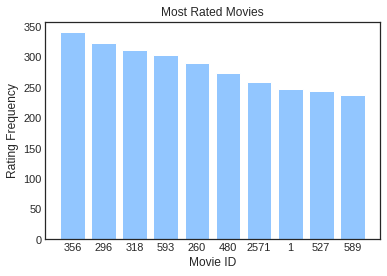

In [ ]:
film_count = df_ratings.groupby('movieId').count()
film_count.orderBy(func.col('count').desc()).show(10)
top_movies = film_count.orderBy(func.col('count').desc()).take(10)

movie_list = [top_movies[i][0] for i in range(len(top_movies))]
value_hist = [top_movies[i][1] for i in range(len(top_movies))]

movie_list = [str(i) for i in movie_list]

y_pos = np.arange(len(value_hist))

plt.bar(movie_list, value_hist, align='center', width=0.8)

plt.title("Most Rated Movies")
plt.ylabel('Rating Frequency')
plt.xlabel('Movie ID')
plt.style.use('seaborn-white')
plt.show()

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['movieId', 'userId']]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(df_ratings).transform(df_ratings)
transformed.show(5)

+------+-------+------+----------+-------------+------------+
|userId|movieId|rating| timestamp|movieId_index|userId_index|
+------+-------+------+----------+-------------+------------+
|     1|     31|   2.5|1260759144|        578.0|       643.0|
|     1|   1029|   3.0|1260759179|        566.0|       643.0|
|     1|   1061|   3.0|1260759182|        742.0|       643.0|
|     1|   1129|   2.0|1260759185|        472.0|       643.0|
|     1|   1172|   4.0|1260759205|        499.0|       643.0|
+------+-------+------+----------+-------------+------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

(training_data, test_data) = transformed.randomSplit([0.7,0.3],seed=221805079)

In [ ]:
als = ALS(rank=10, maxIter=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating")
model=als.fit(training_data)
model.setPredictionCol("newPrediction")
predictions = sorted(model.transform(test_data).collect(), key=lambda r: r[0])
predictions[:5]

[Row(userId=1, movieId=1061, rating=3.0, timestamp=1260759182, movieId_index=742.0, userId_index=643.0, newPrediction=2.303687334060669),
 Row(userId=1, movieId=1287, rating=2.0, timestamp=1260759187, movieId_index=501.0, userId_index=643.0, newPrediction=3.388643980026245),
 Row(userId=1, movieId=1953, rating=4.0, timestamp=1260759191, movieId_index=504.0, userId_index=643.0, newPrediction=2.8004086017608643),
 Row(userId=1, movieId=2105, rating=4.0, timestamp=1260759139, movieId_index=492.0, userId_index=643.0, newPrediction=4.007463455200195),
 Row(userId=1, movieId=2193, rating=2.0, timestamp=1260759198, movieId_index=574.0, userId_index=643.0, newPrediction=2.1552393436431885)]

In [ ]:
user_recs = model.recommendForAllUsers(5)
user_recs.where(user_recs.userId == 1).select("recommendations.movieId", "recommendations.rating").collect()

[Row(movieId=[940, 101, 3685, 537, 48304], rating=[6.467855930328369, 6.273975372314453, 5.806005954742432, 5.665717601776123, 5.50349235534668])]

In [ ]:
item_recs = model.recommendForAllItems(5)
item_recs.where(item_recs.movieId == 1029).select("recommendations.userId", "recommendations.rating").collect()

[Row(userId=[354, 568, 107, 415, 65], rating=[7.6388678550720215, 7.306838512420654, 7.088927268981934, 6.800437927246094, 6.76910400390625])]

In [ ]:
predictions = model.transform(test_data)
# Remove NaN values from prediction (due to SPARK-14489)
predictions = predictions.filter(predictions.newPrediction != float('nan'))
predictions.sort("userId").show(10)

+------+-------+------+----------+-------------+------------+-------------+
|userId|movieId|rating| timestamp|movieId_index|userId_index|newPrediction|
+------+-------+------+----------+-------------+------------+-------------+
|     1|   2294|   2.0|1260759108|        398.0|       643.0|     4.069503|
|     1|   1953|   4.0|1260759191|        504.0|       643.0|    2.8004086|
|     1|   2193|   2.0|1260759198|        574.0|       643.0|    2.1552393|
|     1|   2105|   4.0|1260759139|        492.0|       643.0|    4.0074635|
|     1|   1061|   3.0|1260759182|        742.0|       643.0|    2.3036873|
|     1|   1287|   2.0|1260759187|        501.0|       643.0|     3.388644|
|     2|    588|   3.0| 835355441|         18.0|       314.0|    3.4994683|
|     2|    296|   4.0| 835355395|          1.0|       314.0|    4.0497346|
|     2|     47|   4.0| 835355552|         22.0|       314.0|    3.3070927|
|     2|    185|   3.0| 835355511|        145.0|       314.0|    3.2465348|
+------+----

In [ ]:
evaluator=RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="newPrediction")
rmse=evaluator.evaluate(predictions)
print("RMSE="+str(rmse))


RMSE=1.2055676525058612


In [ ]:
evaluator2=RegressionEvaluator(metricName="mse",labelCol="rating",predictionCol="newPrediction")
mse=evaluator2.evaluate(predictions)
print("MSE="+str(mse))

MSE=1.4533933647684973


In [ ]:
from pyspark.sql.functions import col
test = model.recommendForAllUsers(20).filter(col('userId')== 3).select("recommendations").collect()


In [ ]:
for item in test[0][0]:
    print(item.rating)

7.371940612792969
6.887637138366699
6.798018455505371
6.539734840393066
6.355097770690918
6.352230548858643
6.3454718589782715
6.339486122131348
6.224285125732422
6.175490379333496
6.069018363952637
6.057767391204834
6.042905807495117
6.034675598144531
5.988088130950928
5.937519550323486
5.926024436950684
5.894972801208496
5.859776020050049
5.835057735443115


In [ ]:
from pyspark.sql.types import StructType,StructField,IntegerType
topMovies = []
for item in test[0][0]:
    topMovies.append(item.movieId)
    
schema = StructType([StructField("movieId_index",IntegerType(),True)])
movies = spark.createDataFrame(topMovies,IntegerType()).toDF("movieId_index")

#user's ratings
transformed\
.select(['movieId', 'userId', 'rating', 'movieId_index'])\
.filter(col('userId_index')==35)\
.show(100000)

#Recommendations for user 20
movies\
.join(transformed, on = 'movieId_index', how = 'inner')\
.select(['movieId', 'rating'])\
.drop_duplicates(subset=['movieId'])\
.show(100)


+-------+------+------+-------------+
|movieId|userId|rating|movieId_index|
+-------+------+------+-------------+
|      1|    48|   4.0|          7.0|
|      2|    48|   3.5|        125.0|
|     34|    48|   3.0|         54.0|
|    110|    48|   4.0|         11.0|
|    111|    48|   3.0|        101.0|
|    158|    48|   3.0|        358.0|
|    163|    48|   3.5|        311.0|
|    223|    48|   2.5|        121.0|
|    231|    48|   3.5|         47.0|
|    288|    48|   3.5|        128.0|
|    293|    48|   5.0|         71.0|
|    296|    48|   4.5|          1.0|
|    344|    48|   3.5|         38.0|
|    356|    48|   4.0|          0.0|
|    364|    48|   4.0|         25.0|
|    367|    48|   3.5|         49.0|
|    480|    48|   3.5|          5.0|
|    501|    48|   3.5|       1617.0|
|    527|    48|   4.5|          8.0|
|    541|    48|   4.0|         58.0|
|    562|    48|   3.5|        842.0|
|    593|    48|   3.5|          3.0|
|    595|    48|   3.5|         36.0|
|    648|   